You can perform PID on MI(r;(x,v)), and compare the result of different 'x'.<br>
'x' can from experimental data or produce in this code for different Tau (Gramma) or cutoff frequency.<br>
'r' can be real responses of RGC or from NGD or from x+$\Delta$*v.<br>
Using 20200408 Chou's data, unit2.<br>

# Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy import ndimage
from scipy.io import loadmat
import pandas as pd
import os
%matplotlib inline

In [2]:
import import_ipynb
try:
    os.chdir('C:\\Users\\hydro_leo\\Documents\\GitHub\\python-code\\Modules')
except:
    os.chdir('C:\\Users\\llinc\\GitHub\\python-code\\Modules')
from time_shifted_PID import Histo3D2Dict
from time_shifted_PID import PIfunc
from time_shifted_PID import EqualState
from Spike_Generation import Spike_Time_Generater
from Spike_Generation import NL
from StimulusnResponse import expSnR
from SpatialTemporal_Correlation_and_Convolution import ST_STA
from NGD_TK_AS import NGD2L_TK_AS
from NGD_TK_AS import ParaTrans

importing Jupyter notebook from time_shifted_PID.ipynb
importing Jupyter notebook from J_broja_PID.ipynb
importing Jupyter notebook from Spike_Generation.ipynb
importing Jupyter notebook from StimulusnResponse.ipynb
importing Jupyter notebook from SpatialTemporal_Correlation_and_Convolution.ipynb
importing Jupyter notebook from NGD_TK_AS.ipynb


In [3]:
def angular_gradient(x):
    diffx= np.gradient(x)
    diffx[np.abs(diffx)>0.6*np.pi] -= np.pi*diffx[np.abs(diffx)>0.6*np.pi]/abs(diffx[np.abs(diffx)>0.6*np.pi])
    return diffx

# Load Experimental data

## select files and channels

In [4]:
cn = 53

NGD2L1DASpara = np.load( 'D:\\GoogleDrive\\retina\\Chou\'s data\\20200408\\TKfit\\unit2_fitNGD2LASpara.npz', allow_pickle=True)
for k in NGD2L1DASpara.files:
    vars()[k] = NGD2L1DASpara[k][()]

pd.DataFrame(para_dict).loc[cn-1]

epsilon         14.217523
gamma        73996.448279
omegastar       44.711774
deltastar        0.285205
tau_y            0.071035
Dmp             17.541824
error            0.093686
Name: 52, dtype: float64

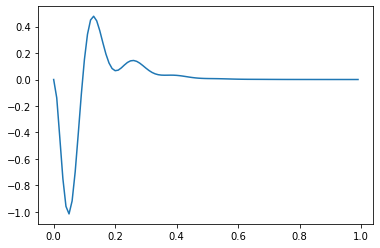

In [5]:
dt = 0.01
T = np.arange(0, 1., dt)
plt.plot(T, NGD2L_TK_AS(T, *pd.DataFrame(para_dict).loc[cn-1][:-1]))

In [6]:
Fc_list = [2,4,7,10]
filenames = ['D:\\GoogleDrive\\retina\\Chou\'s data\\20200408\\20200408_OU_cutoff='+str(Fc)+'_sort_unit2' for Fc in Fc_list]


x_list, T_list, rstate_list = expSnR(filenames, dt, 'LED', [cn])
for i in range(len(x_list)):
    rstate_list[i] = rstate_list[i][cn-1,:]

In [7]:
Dt = 0.01
v_list = [np.append(np.zeros(int(Dt/dt)), x[int(Dt/dt):]-x[:-int(Dt/dt)])/Dt  for x in x_list]
tv_list = [np.append(0, np.diff(x))/dt  for x in x_list]

In [8]:
t_cor_list = []
for i in range(len(x_list)):
    x_cor = np.correlate(x_list[i], x_list[i], "same")
    x_cor = x_cor[:int((len(x_cor)+1)/2)+1]
    Taxis = np.flip(T_list[i][:len(x_cor)]-dt/2)
    t_cor_list.append( round(np.interp(0.5*max(x_cor),  x_cor, Taxis), 3)) 
t_cor_list

[0.534, 0.432, 0.405, 0.395]

In [9]:
#assign states
state_num = 6
xstate_list = [EqualState(x, state_num)[0] for x in x_list]
vstate_list = [EqualState(v, state_num)[0] for v in v_list]
tvstate_list = [EqualState(tv, state_num)[0] for tv in tv_list]

# Real Spike

## Plot MI

In [10]:
window = [-1,1] # second
Real_Information_list = [0]*len(x_list)
for i in range(len(x_list)):
    timeshift, Real_Information_list[i] = PIfunc(rstate_list[i], xstate_list[i], vstate_list[i], dt, window)
Information_list = Real_Information_list.copy()

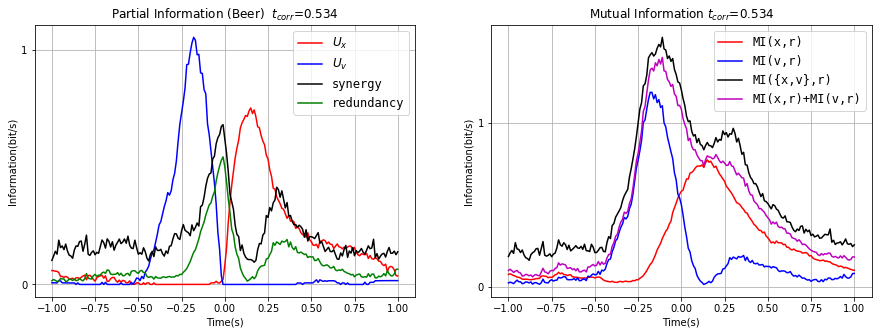

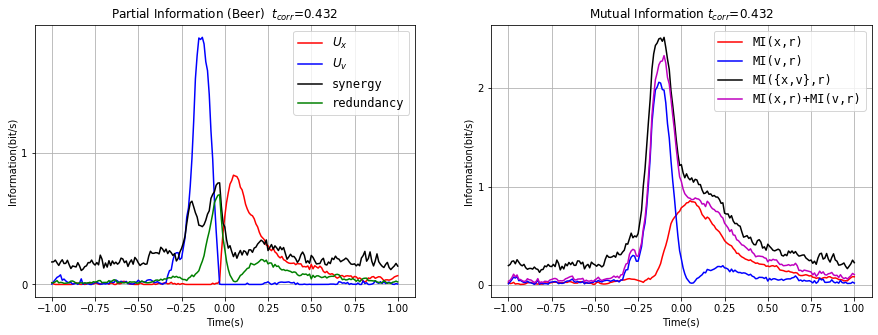

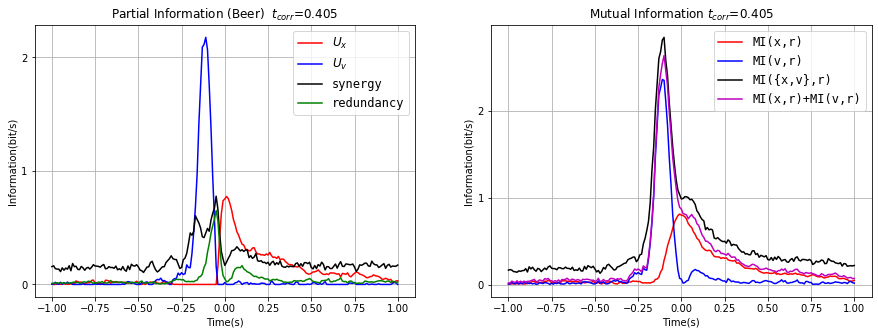

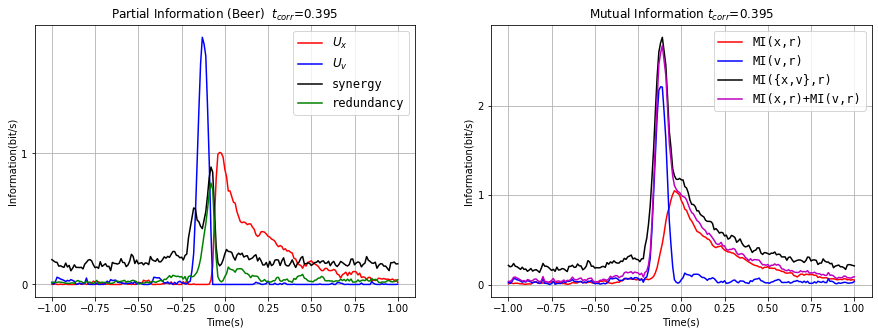

In [11]:
for i in range(len(x_list)):
    fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2) 
    ax2.plot(timeshift,Information_list[i][('Beer','UIx')], 'r-')
    ax2.plot(timeshift,Information_list[i][('Beer','UIv')], 'b-')
    ax2.plot(timeshift,Information_list[i][('Beer','Syn')], 'k-')
    ax2.plot(timeshift,Information_list[i][('Beer','Red')], 'g-')
    ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.set_title('Partial Information (Beer)  '+r'$t_{corr}$='+str(t_cor_list[i]))
    ax2.set_xlabel('Time(s)')
    ax2.set_ylabel('Information(bit/s)')
    ax2.legend( (r'$U_x$', r'$U_v$', 'synergy', 'redundancy'), loc='best', prop={'size': 'large', 'family': 'monospace'})
    ax2.grid()
    
    #plot MIs
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')], 'r-')
    ax3.plot(timeshift,Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Red')], 'b-')
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')]+Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Syn')], 'k-')
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+2*Information_list[i][('Beer','Red')]+Information_list[i][('Beer','UIv')], 'm-')
    ax3.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax3.set_title('Mutual Information '+r'$t_{corr}$='+str(t_cor_list[i]))
    ax3.set_xlabel('Time(s)')
    ax3.set_ylabel('Information(bit/s)')
    ax3.grid()
    ax3.legend( ('MI(x,r)', 'MI(v,r)', 'MI({x,v},r)', 'MI(x,r)+MI(v,r)'), loc='best', prop={'size': 'large', 'family': 'monospace'})
    fig.set_size_inches(15, 5)

x

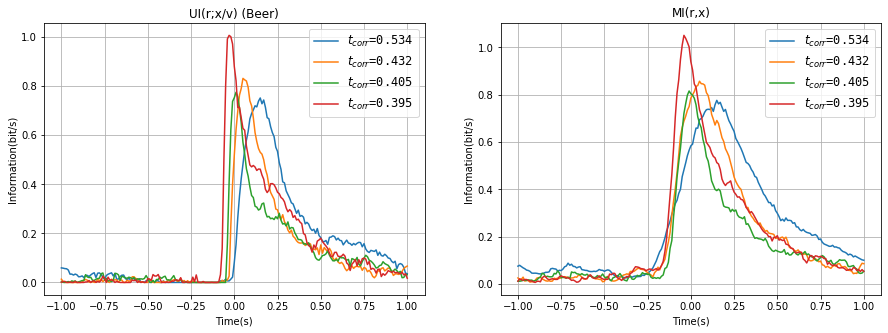

In [12]:
legend_list = []
fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2) 
for i in range(len(x_list)):
    ax2.plot(timeshift,Information_list[i][('Beer','UIx')])
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')])
    legend_list.append (r'$t_{corr}$='+str(t_cor_list[i]))
ax2.set_title('UI(r;x/v) (Beer)')
ax2.set_xlabel('Time(s)')
ax2.set_ylabel('Information(bit/s)')
ax3.set_title('MI(r,x)')
ax3.set_xlabel('Time(s)')
ax3.set_ylabel('Information(bit/s)')
ax2.legend( legend_list , loc='best', prop={'size': 'large', 'family': 'monospace'})
ax3.legend( legend_list , loc='best', prop={'size': 'large', 'family': 'monospace'})
ax3.grid()
ax2.grid()
fig.set_size_inches(15, 5)

# Fake Spike - LC model

## parameters for LC model and Spike Generator

In [38]:
#Assign states
r1state_list = []
ystate_list = [0]*len(x_list)
yLC_list = [0]*len(x_list)
# Delta_list = [0.4, 0.3, 0.26, 0.24]
# Delta_list = [.9, .9, .9, .9]
FakeSpike_list = [0]*len(x_list)
for i in range(len(x_list)):
    Lambda = 0.45
    r1 = ndimage.gaussian_filter1d( (1-Lambda)*x_list[i]+Lambda*v_list[i] , 10 )
    yLC_list[i] =  (1-Lambda)*x_list[i]+Lambda*v_list[i] 
    r = NL(r1-np.mean(r1), 0)
    ratio = sum(r)/T_list[i][-1]/2
    FakeSpike_list[i] = Spike_Time_Generater(r/ratio, dt, 10)
    ystate_list[i], _ = np.histogram(FakeSpike_list[i], np.append(0,T_list[i]))

In [14]:
T_LC = np.arange(0,1,Dt/10)
lTKLC = np.zeros_like(T_LC)
lTKLC[60] = 1-Lambda+(Lambda/Dt)
lTKLC[70] = -(Lambda/Dt)
lTKLC = lTKLC/dt
TKLC = lTKLC[::10]

# T_LC = np.arange(0,1,Dt)
# TKLC = np.zeros_like(T_LC)
# TKLC[0] = 1-Lambda+(Lambda/Dt)
# TKLC[1] = -(Lambda/Dt)
# TKLC = TKLC/Dt

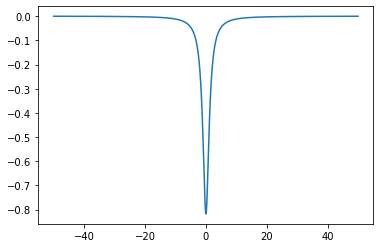

In [15]:
dOmega = 0.05
omega = np.arange(-50,50,dOmega)
H = (1-Lambda+Lambda*1j*omega)#/(omega*1j)
Phi = np.angle(H)
delta = -angular_gradient(Phi)/dOmega
GDfig, GDax = plt.subplots()
GDax.plot(omega, delta)
# GDax.set_xlim([0, 30])

In [16]:
# tempT = np.arange(-1,1,0.0002)
# iF_H = np.sum(H[:,np.newaxis]*np.exp(-1j*tempT[np.newaxis,:]*omega[:,np.newaxis]), axis = 0)*dOmega/ (2*np.pi)

# TKLC = np.zeros(10*len(TKLC))
# T_LC = np.arange(0,1,Dt/10)
# TKLC[0] = 1
# TKLC[10] = 1-Lambda+(Lambda/Dt)
F_TK = np.sum(lTKLC[np.newaxis,:]*np.exp(1j*T_LC[np.newaxis,:]*omega[:,np.newaxis]), axis = 1)*Dt
# tempT = np.arange(-1,1,0.005)
iFF_F_TK = np.sum(F_TK[:,np.newaxis]*np.exp(-1j*T_LC[np.newaxis,:]*omega[:,np.newaxis]), axis = 0)*dOmega/ (2*np.pi)

(-500, 500)

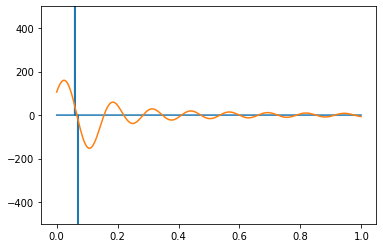

In [17]:
# plt.plot(tempT, iF_H)
plt.plot(T_LC, lTKLC)
plt.plot(T_LC, iFF_F_TK)
plt.ylim([-500, 500])

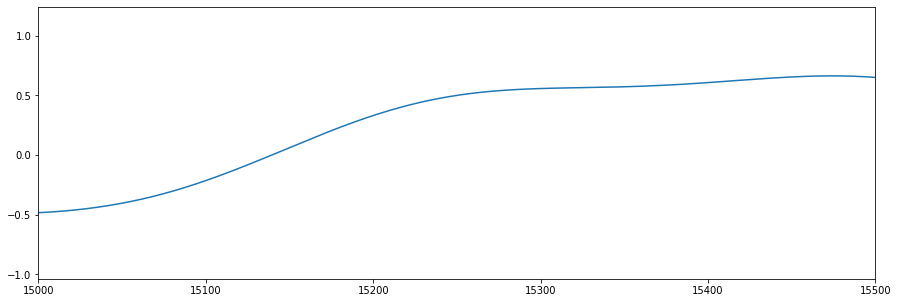

In [35]:
i = 3
plt.plot(yLC_list[i])
# plt.plot(ndimage.gaussian_filter1d(yLC_list[i], 1))

plt.xlim([15000, 15500])
plt.gcf().set_size_inches(15,5)

## Plot MI

In [39]:
window = [-1,1] # second
LC_Information_list = [0]*len(x_list)
for i in range(len(x_list)):
    timeshift, LC_Information_list[i] = PIfunc(ystate_list[i], xstate_list[i], tvstate_list[i], dt, window)
Information_list = LC_Information_list.copy()

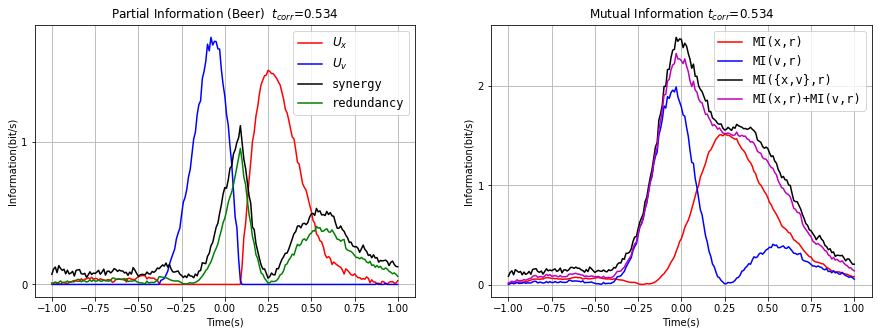

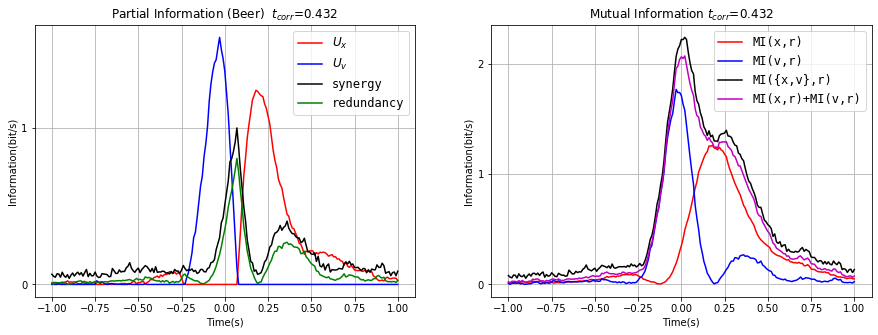

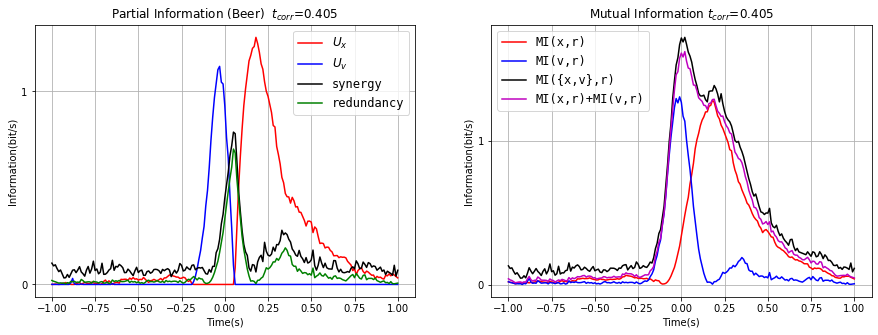

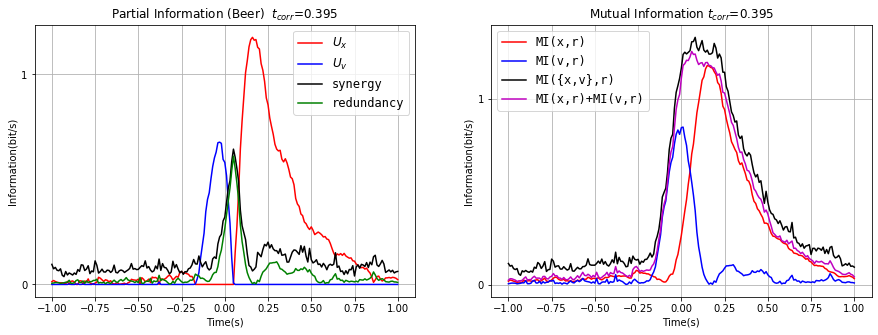

In [40]:
for i in range(len(x_list)):
    fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2) 
    ax2.plot(timeshift,Information_list[i][('Beer','UIx')], 'r-')
    ax2.plot(timeshift,Information_list[i][('Beer','UIv')], 'b-')
    ax2.plot(timeshift,Information_list[i][('Beer','Syn')], 'k-')
    ax2.plot(timeshift,Information_list[i][('Beer','Red')], 'g-')
    ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.set_title('Partial Information (Beer)  '+r'$t_{corr}$='+str(t_cor_list[i]))
    ax2.set_xlabel('Time(s)')
    ax2.set_ylabel('Information(bit/s)')
    ax2.legend( (r'$U_x$', r'$U_v$', 'synergy', 'redundancy'), loc='best', prop={'size': 'large', 'family': 'monospace'})
    ax2.grid()
    
    #plot MIs
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')], 'r-')
    ax3.plot(timeshift,Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Red')], 'b-')
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')]+Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Syn')], 'k-')
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+2*Information_list[i][('Beer','Red')]+Information_list[i][('Beer','UIv')], 'm-')
    ax3.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax3.set_title('Mutual Information '+r'$t_{corr}$='+str(t_cor_list[i]))
    ax3.set_xlabel('Time(s)')
    ax3.set_ylabel('Information(bit/s)')
    ax3.grid()
    ax3.legend( ('MI(x,r)', 'MI(v,r)', 'MI({x,v},r)', 'MI(x,r)+MI(v,r)'), loc='best', prop={'size': 'large', 'family': 'monospace'})
    fig.set_size_inches(15, 5)

x

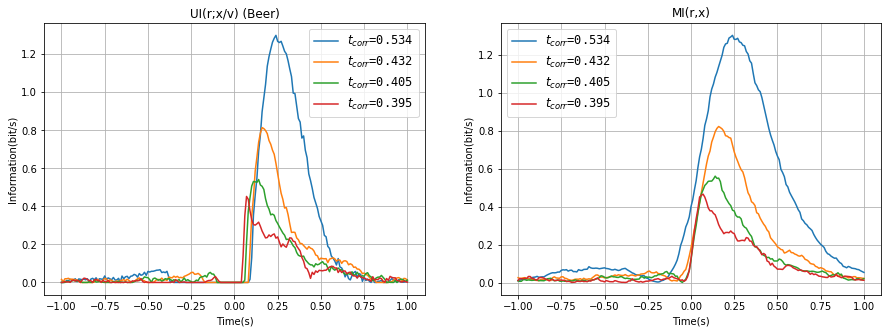

In [20]:
legend_list = []
fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2) 
for i in range(len(x_list)):
    ax2.plot(timeshift,Information_list[i][('Beer','UIx')])
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')])
    legend_list.append (r'$t_{corr}$='+str(t_cor_list[i]))
ax2.set_title('UI(r;x/v) (Beer)')
ax2.set_xlabel('Time(s)')
ax2.set_ylabel('Information(bit/s)')
ax3.set_title('MI(r,x)')
ax3.set_xlabel('Time(s)')
ax3.set_ylabel('Information(bit/s)')
ax2.legend( legend_list , loc='best', prop={'size': 'large', 'family': 'monospace'})
ax3.legend( legend_list , loc='best', prop={'size': 'large', 'family': 'monospace'})
ax3.grid()
ax2.grid()
fig.set_size_inches(15, 5)